In [1]:
import pandas as pd
import os
from datetime import datetime
import sqlite3
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

%matplotlib inline

In [2]:
# function to convert datetime object to 4 - for force ONLY
def datetime(df, col_as_str):
    yearmonthday = df[col_as_str].astype(str).str.split(" ")
    ymd = yearmonthday.apply(lambda x: x[0]).str.split("/")
    year = ymd.apply(lambda x: x[2])
    month = ymd.apply(lambda x: x[0])
    day = ymd.apply(lambda x: x[1])
    time = ymd = yearmonthday.apply(lambda x: x[1]+x[2]).astype(str)
    df["year"] = year
    df["month"] = month
    df["day"] = day
    df["time"] = time
    return df


In [3]:
def callstime(df, col_arrive):
    yearmonthday = df[col_arrive].astype(str).str.split(" ")
    df["year"] = yearmonthday.apply(lambda x: x[2])
    df["day"] = yearmonthday.apply(lambda x: x[1])
    month_dict = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec":12}
    df["month"] = yearmonthday.apply(lambda x: month_dict[x[0]])
    df["time"] = yearmonthday.apply(lambda x: x[3])
    return df
    
    

In [4]:
calls = pd.read_csv("/Users/sarahburgart/galvanize/week7/capstone2/data/Call_Data.csv")

In [5]:
force = pd.read_csv("/Users/sarahburgart/galvanize/week7/capstone2/data/Use_Of_Force.csv")

In [12]:
#beats = pd.read_csv("/Users/sarahburgart/galvanize/week7/capstone2/data/Seattle_Police_Department_Beats.csv")

In [6]:
# change to epoch time
force = datetime(force,"Occured_date_time" )
foo = pd.to_datetime( force.Occured_date_time )
epoch_second = foo.map(lambda x:x.value/1e9)


In [7]:
force["epoch"] = epoch_second

In [8]:
force.head() # ID = Incident Num, Officer ID, Subject ID

,ID,Incident_Num,Incident_Type,Occured_date_time,Precinct,Sector,Beat,Officer_ID,Subject_ID,Subject_Race,Subject_Gender,year,month,day,time,epoch
0,18412-2238-14470,18412,Level 1 - Use of Force,11/28/2017 01:40:00 AM,-,-,-,2238,14470,Black or African American,Female,2017,11,28,01:40:00AM,1.511833e+09
1,16162-1589-12833,16162,Level 1 - Use of Force,06/22/2017 04:15:00 AM,-,-,-,1589,12833,Black or African American,Male,2017,06,22,04:15:00AM,1.498105e+09
2,30638-2146-17272,30638,Level 1 - Use of Force,07/21/2018 06:58:00 PM,-,-,-,2146,17272,White,Male,2018,07,21,06:58:00PM,1.532199e+09
3,37423-2484-18496,37423,Level 1 - Use of Force,11/17/2018 01:19:00 PM,-,-,-,2484,18496,Black or African American,Female,2018,11,17,01:19:00PM,1.542461e+09
4,35955-1708-18238,35955,Level 1 - Use of Force,10/21/2018 11:04:00 PM,-,-,-,1708,18238,White,Female,2018,10,21,11:04:00PM,1.540163e+09


In [9]:
calls = callstime(calls,"Arrived Time")


In [10]:
calls17 = calls[calls["year"].isin(["2014", "2015", "2016", "2017", "2018", "2019"])]

In [11]:
# calculate and add column for epoch time
bar = pd.to_datetime( calls17["Arrived Time"], format="%b %d %Y %I:%M:%S:%f%p" )
epoch_second2 = bar.map(lambda x: x.value/1e9)
calls17["epoch_calls"] = epoch_second2


/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [12]:
# remove repetitive columns

calls_tosql = calls17.drop(columns =["year","day", "month", "time", "Precinct", "Sector", "Arrived Time"])
calls_tosql.set_index("epoch_calls", inplace=True)


In [13]:
# remove repetitive columns (incident type, officer id and subject id are in ID respectively)

force = force.drop(columns=["Occured_date_time", "ID"])


In [93]:
force.epoch.head()

0    1.511833e+09
1    1.498105e+09
2    1.532199e+09
3    1.542461e+09
4    1.540163e+09
Name: epoch, dtype: float64

In [100]:
force.epoch.value_counts()
#force.epoch.values

1.398978e+09    24
1.397868e+09    24
1.398985e+09    24
1.496770e+09    18
1.448154e+09    16
1.450474e+09    16
1.398977e+09    15
1.420063e+09    15
1.397519e+09    12
1.400625e+09    11
1.489855e+09    10
1.553703e+09    10
1.493694e+09    10
1.543444e+09     9
1.398883e+09     9
1.513534e+09     8
1.430509e+09     8
1.398546e+09     8
1.434158e+09     8
1.402848e+09     8
1.462131e+09     8
1.430510e+09     8
1.416866e+09     8
1.508362e+09     8
1.491215e+09     8
1.451437e+09     8
1.522245e+09     8
1.419970e+09     7
1.396461e+09     7
1.434119e+09     7
                ..
1.397427e+09     1
1.498105e+09     1
1.544998e+09     1
1.531673e+09     1
1.411184e+09     1
1.531517e+09     1
1.464408e+09     1
1.464403e+09     1
1.531410e+09     1
1.531412e+09     1
1.442771e+09     1
1.518732e+09     1
1.517533e+09     1
1.464318e+09     1
1.430767e+09     1
1.459584e+09     1
1.510943e+09     1
1.534114e+09     1
1.531440e+09     1
1.497890e+09     1
1.430783e+09     1
1.531461e+09

In [101]:
force[force.epoch == 1.398978e+09 ] #np.allclose

,Incident_Num,Incident_Type,Precinct,Sector,Beat,Officer_ID,Subject_ID,Subject_Race,Subject_Gender,year,month,day,time,epoch
799,1780,Level 1 - Use of Force,E,E,E1,1538,1680,White,Male,2014,05,01,09:00:00PM,1.398978e+09
1049,1549,Level 1 - Use of Force,W,D,D2,1682,341,White,Male,2014,05,01,09:00:00PM,1.398978e+09


In [102]:
calls17.head()

,CAD Event Number,Event Clearance Description,Call Type,Priority,Initial Call Type,Final Call Type,Original Time Queued,Arrived Time,Precinct,Sector,Beat,year,day,month,time,epoch_calls
1674201,2014000010473,ASSISTANCE RENDERED,ONVIEW,9,OFF DUTY EMPLOYMENT,-OFF DUTY EMPLOYMENT,01/10/2014 04:02:48 PM,Jan 10 2014 04:02:48:000PM,WEST,MARY,M3,2014,10,1,04:02:48:000PM,1.389370e+09
1674409,2014000010474,ASSISTANCE RENDERED,ONVIEW,9,OFF DUTY EMPLOYMENT,-OFF DUTY EMPLOYMENT,01/10/2014 04:03:51 PM,Jan 10 2014 04:03:51:000PM,WEST,MARY,M1,2014,10,1,04:03:51:000PM,1.389370e+09
1674513,2014000011094,ASSISTANCE RENDERED,ONVIEW,4,REQUEST TO WATCH,REQUEST TO WATCH,01/11/2014 04:23:57 AM,Jan 11 2014 04:23:57:000AM,WEST,KING,K2,2014,11,1,04:23:57:000AM,1.389414e+09
1674584,2014000011246,ASSISTANCE RENDERED,ONVIEW,9,OFF DUTY EMPLOYMENT,-OFF DUTY EMPLOYMENT,01/11/2014 08:43:16 AM,Jan 11 2014 08:43:16:000AM,WEST,MARY,M3,2014,11,1,08:43:16:000AM,1.389430e+09
1675205,2014000013754,ASSISTANCE RENDERED,ONVIEW,9,OFF DUTY EMPLOYMENT,-OFF DUTY EMPLOYMENT,01/13/2014 04:28:49 PM,Jan 13 2014 04:28:49:000PM,WEST,MARY,M1,2014,13,1,04:28:49:000PM,1.389631e+09


In [14]:
# create engine
cnx = sqlite3.connect('/Users/sarahburgart/galvanize/week7/capstone2/calls.sqlite')

In [24]:
# move calls to sqlite table - DONT REPEAT
# calls_tosql.to_sql("log", con=cnx, index=True)


/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2531: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype, method=method)


In [16]:
calls_tosql.head()

,CAD Event Number,Event Clearance Description,Call Type,Priority,Initial Call Type,Final Call Type,Original Time Queued,Beat
epoch_calls,,,,,,,,
1.389370e+09,2014000010473,ASSISTANCE RENDERED,ONVIEW,9,OFF DUTY EMPLOYMENT,-OFF DUTY EMPLOYMENT,01/10/2014 04:02:48 PM,M3
1.389370e+09,2014000010474,ASSISTANCE RENDERED,ONVIEW,9,OFF DUTY EMPLOYMENT,-OFF DUTY EMPLOYMENT,01/10/2014 04:03:51 PM,M1
1.389414e+09,2014000011094,ASSISTANCE RENDERED,ONVIEW,4,REQUEST TO WATCH,REQUEST TO WATCH,01/11/2014 04:23:57 AM,K2
1.389430e+09,2014000011246,ASSISTANCE RENDERED,ONVIEW,9,OFF DUTY EMPLOYMENT,-OFF DUTY EMPLOYMENT,01/11/2014 08:43:16 AM,M3
1.389631e+09,2014000013754,ASSISTANCE RENDERED,ONVIEW,9,OFF DUTY EMPLOYMENT,-OFF DUTY EMPLOYMENT,01/13/2014 04:28:49 PM,M1


In [15]:
# create cursor
cur = cnx.cursor()


In [16]:
test = cur.execute("SELECT * from log LIMIT 10").fetchall()
for row in test:
    print(row)

cnx.commit()

(1389369768.0, 2014000010473, 'ASSISTANCE RENDERED', 'ONVIEW', 9, 'OFF DUTY EMPLOYMENT', '-OFF DUTY EMPLOYMENT', '01/10/2014 04:02:48 PM', 'M3')
(1389369831.0, 2014000010474, 'ASSISTANCE RENDERED', 'ONVIEW', 9, 'OFF DUTY EMPLOYMENT', '-OFF DUTY EMPLOYMENT', '01/10/2014 04:03:51 PM', 'M1')
(1389414237.0, 2014000011094, 'ASSISTANCE RENDERED', 'ONVIEW', 4, 'REQUEST TO WATCH', 'REQUEST TO WATCH', '01/11/2014 04:23:57 AM', 'K2')
(1389429796.0, 2014000011246, 'ASSISTANCE RENDERED', 'ONVIEW', 9, 'OFF DUTY EMPLOYMENT', '-OFF DUTY EMPLOYMENT', '01/11/2014 08:43:16 AM', 'M3')
(1389630529.0, 2014000013754, 'ASSISTANCE RENDERED', 'ONVIEW', 9, 'OFF DUTY EMPLOYMENT', '-OFF DUTY EMPLOYMENT', '01/13/2014 04:28:49 PM', 'M1')
(1389631222.0, 2014000013755, 'REPORT WRITTEN (NO ARREST)', '911', 2, 'SHOPLIFT - THEFT', '--THEFT - SHOPLIFT', '01/13/2014 04:28:54 PM', 'K2')
(1389677005.0, 2014000014333, 'OTHER REPORT MADE', 'ONVIEW', 3, 'FOLLOW UP', '--WARRANT SERVICES - FELONY', '01/14/2014 05:23:25 AM', 'D2'

In [28]:
#cur.execute("CREATE INDEX index_name ON log (epoch_calls)")
#don't repeat - already there!

In [19]:
# testing index
test_i = cur.execute("select * from log where epoch_calls > 1511833200.0 limit 10").fetchall()
cnx.commit()

print(test_i)
# 1389369768.0

[(1511833270.0, 2017000438602, 'ORAL WARNING GIVEN', 'ONVIEW', 7, 'TRAFFIC STOP - OFFICER INITIATED ONVIEW', '--TRAFFIC - MOVING VIOLATION', '11/28/2017 01:41:10 AM', 'C3'), (1511833290.0, 2017000438599, 'ORAL WARNING GIVEN', '911', 2, 'DISTURBANCE, MISCELLANEOUS/OTHER', '--DISTURBANCE - OTHER', '11/28/2017 01:34:37 AM', 'D1'), (1511833452.0, 2017000438604, 'ASSISTANCE RENDERED', 'ONVIEW', 3, 'DISTURBANCE, MISCELLANEOUS/OTHER', '--DISTURBANCE - OTHER', '11/28/2017 01:44:11 AM', 'N3'), (1511833619.0, 2017000438605, 'PHYSICAL ARREST MADE', 'ONVIEW', 7, 'FOOT - ELUDING POLICE', '--WARRANT SERVICES - FELONY', '11/28/2017 01:46:58 AM', 'M2'), (1511834149.0, 2017000438603, 'ASSISTANCE RENDERED', 'TELEPHONE OTHER, NOT 911', 3, 'SUSPICIOUS PERSON, VEHICLE OR INCIDENT', '--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON', '11/28/2017 01:43:52 AM', 'S2'), (1511834189.0, 2017000438606, 'CITATION ISSUED (CRIMINAL OR NON-CRIMINAL)', 'ONVIEW', 7, 'TRAFFIC STOP - OFFICER INITIATED ONVIEW', '--TRAFFIC - MOVING

In [17]:
force10 = force.head(5)
#new_df = pd.DataFrame(force10.iterrows())

#force.drop(columns=["Incident_Num", "Occured_date_time", "Officer_ID", "Subject_ID"], inplace=True)
#sum(force[force.Beat == "-"].count()), len(force)
force10

,Incident_Num,Incident_Type,Precinct,Sector,Beat,Officer_ID,Subject_ID,Subject_Race,Subject_Gender,year,month,day,time,epoch
0,18412,Level 1 - Use of Force,-,-,-,2238,14470,Black or African American,Female,2017,11,28,01:40:00AM,1.511833e+09
1,16162,Level 1 - Use of Force,-,-,-,1589,12833,Black or African American,Male,2017,06,22,04:15:00AM,1.498105e+09
2,30638,Level 1 - Use of Force,-,-,-,2146,17272,White,Male,2018,07,21,06:58:00PM,1.532199e+09
3,37423,Level 1 - Use of Force,-,-,-,2484,18496,Black or African American,Female,2018,11,17,01:19:00PM,1.542461e+09
4,35955,Level 1 - Use of Force,-,-,-,1708,18238,White,Female,2018,10,21,11:04:00PM,1.540163e+09


In [18]:
# iterate through the dataframe 'force', make a bunch of new rows, and then make a dataframe out of those

new_row = []
#val_lst = []
for ix, row in force.iterrows():
    # query the 911 calls database
    # for each call, append to a bunch of records that we're building up into a dataframe
    value = row.epoch
    rowbeat = row.Beat
    vals = cur.execute(f"select * from log where epoch_calls BETWEEN ({value} - 1200) AND {value} ").fetchall()
    #val_lst.extend([value, val[0]])
    cnx.commit()
    
    for val in vals:
        new_row.extend( [[ix,  val[0], row.epoch, row.Incident_Num, row.Officer_ID, row.Subject_ID, val[1], val[2],
                        row.Incident_Type, row.Precinct, 
                        row.Sector, row.Beat, val[8], val[4],
                        row.Subject_Race, row.Subject_Gender, val[3], val[5], val[6], 
                        val[7], row.year, row.month, row.day, row.time] ])
  

In [19]:
merged = pd.DataFrame(new_row, columns=["index","call_epoch", "force_epoch", "Incident_Num", "Officer_ID",
                                        "Subject_ID", "CAD_Event_Number", "Event_Clearance_Description",
                                "Force_Level", "Precinct", 
                                "Sector", "force_beat", "calls_beat", "Priority",
                                "Subject_Race", "Subject_Gender","Call_Type", "Initial_Call_Type", "Final_Call_Type",
                                "Original_Time_Queued", "year", "month","day", "time " ])



In [20]:
lst = []
for value in list(force.iloc[:2,:].epoch.values):
    val = cur.execute(f"select * from log where epoch_calls BETWEEN ({value} - 14400) AND {value} limit 1").fetchall()
    lst.append(val)
cnx.commit()

# 4 hours = 14400 seconds

In [106]:
merged.call_epoch = pd.to_numeric(merged.call_epoch, downcast="integer")

In [108]:
merged.force_epoch = pd.to_numeric(merged.force_epoch, downcast="integer")

In [111]:
force3 = merged[merged.Force_Level == "Level 3 - Use of Force"]
force2 = merged[merged.Force_Level == "Level 2 - Use of Force"]
force1 = merged[merged.Force_Level == "Level 1 - Use of Force"]

In [112]:
len(force3), len(force2), len(force1), len(merged)

(1217, 23921, 83761, 109526)

In [113]:
force3.Incident_Num.value_counts()
t = force3[force3["Incident_Num"] == 12308]
#t.drop_duplicates("CAD_Event_Number", inplace=True) # 'force_beat', 'calls_beat'
len(t.CAD_Event_Number.value_counts()), len(t)
t2 = t[t.force_beat.values == t.calls_beat.values]
t2

,index,call_epoch,force_epoch,Incident_Num,Officer_ID,Subject_ID,CAD_Event_Number,Event_Clearance_Description,Force_Level,Precinct,...,Subject_Race,Subject_Gender,Call_Type,Initial_Call_Type,Final_Call_Type,Original_Time_Queued,year,month,day,time
62572,5879,1471550409,1471551600,12308,2191,1174,2016000299568,PHYSICAL ARREST MADE,Level 3 - Use of Force,N,...,Black or African American,Male,"TELEPHONE OTHER, NOT 911",THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--WARRANT SERVICES - MISDEMEANOR,08/18/2016 07:57:10 PM,2016,08,18,08:20:00PM
62576,5879,1471550593,1471551600,12308,2191,1174,2016000299574,REPORT WRITTEN (NO ARREST),Level 3 - Use of Force,N,...,Black or African American,Male,ONVIEW,AUTO RECOVERY,--AUTOMOBILES - RECOVERY (THEFT),08/18/2016 08:03:13 PM,2016,08,18,08:20:00PM
62592,5880,1471550409,1471551600,12308,2191,9391,2016000299568,PHYSICAL ARREST MADE,Level 3 - Use of Force,N,...,White,Female,"TELEPHONE OTHER, NOT 911",THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--WARRANT SERVICES - MISDEMEANOR,08/18/2016 07:57:10 PM,2016,08,18,08:20:00PM
62596,5880,1471550593,1471551600,12308,2191,9391,2016000299574,REPORT WRITTEN (NO ARREST),Level 3 - Use of Force,N,...,White,Female,ONVIEW,AUTO RECOVERY,--AUTOMOBILES - RECOVERY (THEFT),08/18/2016 08:03:13 PM,2016,08,18,08:20:00PM


In [114]:
force3beats = force3[force3.force_beat.values == force3.calls_beat.values]
len(force3beats)
f3b = force3beats.drop(["index", "Force_Level", "Precinct"], axis=1)
f3b.drop("Sector", axis=1, inplace=True)
f3b 

,call_epoch,force_epoch,Incident_Num,Officer_ID,Subject_ID,CAD_Event_Number,Event_Clearance_Description,force_beat,calls_beat,Priority,Subject_Race,Subject_Gender,Call_Type,Initial_Call_Type,Final_Call_Type,Original_Time_Queued,year,month,day,time
1026,1489590165,1489590540,14862,1585,8260,2017000092147,STREET CHECK WRITTEN,N3,N3,7,American Indian/Alaska Native,Male,ONVIEW,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--PROWLER - TRESPASS,03/15/2017 03:02:45 PM,2017,03,15,03:09:00PM
3318,1405207610,1405208520,479,927,432,2014000227899,FOLLOW-UP REPORT MADE,D1,D1,3,White,Male,ONVIEW,FOLLOW UP,"--WEAPON,PERSON WITH - OTHER WEAPON",07/12/2014 11:26:50 PM,2014,07,12,11:42:00PM
3683,1403395948,1403396940,305,408,257,2014000199270,UNABLE TO LOCATE INCIDENT OR COMPLAINANT,K3,K3,1,Black or African American,Male,911,ASLT - WITH OR W/O WEAPONS (NO SHOOTINGS),"--ASSAULTS, OTHER",06/22/2014 12:10:15 AM,2014,06,22,12:29:00AM
4190,1403739051,1403739600,340,1640,289,2014000204516,PHYSICAL ARREST MADE,D3,D3,7,Black or African American,Male,ONVIEW,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,"--ASSAULTS, OTHER",06/25/2014 11:30:51 PM,2014,06,25,11:40:00PM
6565,1409397806,1409398800,973,1665,1002,2014000289592,ASSISTANCE RENDERED,B1,B1,2,Not Specified,Male,911,TRESPASS,--ASSIST PUBLIC - OTHER (NON-SPECIFIED),08/30/2014 10:49:45 AM,2014,08,30,11:40:00AM
6577,1409397806,1409398800,974,1616,1003,2014000289592,ASSISTANCE RENDERED,B1,B1,2,Hispanic or Latino,Male,911,TRESPASS,--ASSIST PUBLIC - OTHER (NON-SPECIFIED),08/30/2014 10:49:45 AM,2014,08,30,11:40:00AM
11064,1482422810,1482423960,14331,456,8910,2016000458799,CITATION ISSUED (CRIMINAL OR NON-CRIMINAL),M3,M3,3,Not Specified,Male,ONVIEW,PARKING VIOLATION (EXCEPT ABANDONED CAR),--TRAFFIC - PARKING VIOL (EXCEPT ABANDONED CAR),12/22/2016 04:06:50 PM,2016,12,22,04:26:00PM
11067,1482422883,1482423960,14331,456,8910,2016000458802,ASSISTANCE RENDERED,M3,M3,9,Not Specified,Male,ONVIEW,OFF DUTY EMPLOYMENT,-OFF DUTY EMPLOYMENT,12/22/2016 04:08:03 PM,2016,12,22,04:26:00PM
11077,1482423135,1482423960,14331,456,8910,2016000458809,ASSISTANCE RENDERED,M3,M3,7,Not Specified,Male,ONVIEW,"PREMISE CHECK, OFFICER INITIATED ONVIEW ONLY",--PREMISE CHECKS - CRIME PREVENTION,12/22/2016 04:12:15 PM,2016,12,22,04:26:00PM
11081,1482423226,1482423960,14331,456,8910,2016000458812,PHYSICAL ARREST MADE,M3,M3,2,Not Specified,Male,ONVIEW,"NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)",--NARCOTICS - DRUG TRAFFIC LOITERING,12/22/2016 04:13:45 PM,2016,12,22,04:26:00PM


In [ ]:
for col in t.columns:
    print(t[f"{col}"].value_counts())

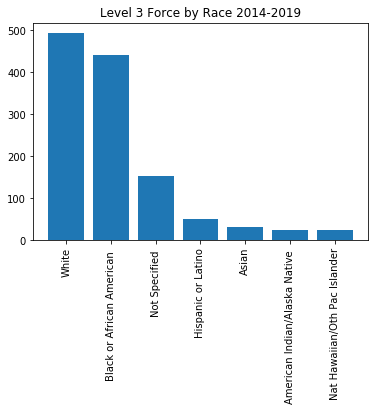

In [62]:
# group by incident number first

x = force3.Subject_Race.value_counts()
lst = list(x.values)
plt.bar(np.arange(7), lst)
#plt.xticks([])
#plt.xticks()

plt.xticks((0,1, 2, 3,4,5,6), ('White', 'Black or African American ', 'Not Specified ','Hispanic or Latino',
                               'Asian','American Indian/Alaska Native ','Nat Hawaiian/Oth Pac Islander'), 
          rotation='vertical')
plt.title("Level 3 Force by Race 2014-2019");

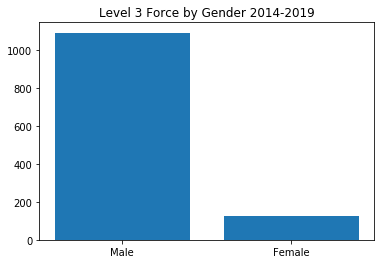

In [82]:
y = force3.Subject_Gender.value_counts()
lst = list(y.values)
plt.bar(np.arange(2), lst)
#plt.xticks([])
#plt.xticks()

plt.xticks((0,1), ('Male', 'Female'), 
          rotation='horizontal')
plt.title("Level 3 Force by Gender 2014-2019");

In [124]:
ecd = list(enumerate(merged.Event_Clearance_Description.value_counts().index))
ecdict  = {x:i for i,x in enumerate(merged.Event_Clearance_Description.value_counts().index)}
ecdict

{'ASSISTANCE RENDERED': 0,
 'REPORT WRITTEN (NO ARREST)': 1,
 'UNABLE TO LOCATE INCIDENT OR COMPLAINANT': 2,
 'PHYSICAL ARREST MADE': 3,
 'ORAL WARNING GIVEN': 4,
 'CITATION ISSUED (CRIMINAL OR NON-CRIMINAL)': 5,
 'NO POLICE ACTION POSSIBLE OR NECESSARY': 6,
 'OTHER REPORT MADE': 7,
 'PROBLEM SOLVING PROJECT': 8,
 'FALSE COMPLAINT/UNFOUNDED': 9,
 'FOLLOW-UP REPORT MADE': 10,
 'STREET CHECK WRITTEN': 11,
 'DUPLICATED OR CANCELLED BY RADIO': 12,
 'INCIDENT LOCATED, PUBLIC ORDER RESTORED': 13,
 'TRANSPORTATION OR ESCORT PROVIDED': 14,
 '-': 15,
 'RESPONDING UNIT(S) CANCELLED BY RADIO': 16,
 'RADIO BROADCAST AND CLEAR': 17,
 'SERVICE OF DVPA ORDER': 18,
 'NON-CRIMINAL REFERRAL': 19,
 'EXTRA UNIT': 20,
 'NO SUCH ADDRESS OR LOCATION': 21,
 '(NOT CURRENTLY USED) ALARM NO RESPONSE': 22}

In [125]:
merged["Event_Clearance_Description"] = merged["Event_Clearance_Description"].map(lambda x: ecdict[x])


In [145]:
pd.get_dummmies(rev_df.force_beat)

AttributeError: module 'pandas' has no attribute 'get_dummmies'

In [143]:
# make everything numerical
# rev_df = merged.replace("-", -1)
rev_df = merged.replace("-1", -1)
rev_df.Force_Level = rev_df.Force_Level.replace({"Level 1 - Use of Force": 1, "Level 2 - Use of Force": 2, "Level 3 - Use of Force": 3, "Level 3 - OIS": 4})
rev_df.Subject_Gender = rev_df.Subject_Gender.replace({"Female":1, "Male":0})
rev_df["NineOneOne"] = rev_df.Call_Type.where(rev_df.Call_Type == "911", 1).where(rev_df.Call_Type != "911", 0)
rev_df["OnviewCall"] = rev_df.Call_Type.where(rev_df.Call_Type == "ONVIEW", 1).where(rev_df.Call_Type != "ONVIEW", 0)
rev_df["TelephoneOther"] = rev_df.Call_Type.where(rev_df.Call_Type == "TELEPHONE OTHER, NOT 911", 1).where(rev_df.Call_Type != "TELEPHONE OTHER, NOT 911", 0)
rev_df["Alarm"] = rev_df.Call_Type.where(rev_df.Call_Type == "ALARM CALL (NOT POLICE ALARM) ", 1).where(rev_df.Call_Type != "ALARM CALL (NOT POLICE ALARM) ", 0)
rev_df["Retro"] = rev_df.Call_Type.where(rev_df.Call_Type == "HISTORY CALL (RETRO)", 1).where(rev_df.Call_Type != "HISTORY CALL (RETRO)", 0)
rev_df["ScheduledRecurring"] = rev_df.Call_Type.where(rev_df.Call_Type == "SCHEDULED EVENT (RECURRING)", 1).where(rev_df.Call_Type != "SCHEDULED EVENT (RECURRING)", 0)


beats = rev_df.force_beat.value_counts()

E2    6018
-     5219
N3    4390
K2    4231
XX    3767
K3    3473
M3    3174
D2    3168
R2    3079
K1    3037
N2    3026
S1    2821
S2    2569
M1    2487
M2    2431
D1    2343
G1    2284
S3    2113
G2    2078
O1    2075
D3    1940
U2    1930
E1    1918
L1    1890
U1    1884
E3    1833
R1    1829
B1    1824
G3    1795
L2    1753
R3    1658
J1    1539
F2    1517
L3    1497
J3    1447
F1    1347
C1    1298
C3    1285
F3    1277
Q3    1258
N1    1249
W1    1213
U3    1188
B3    1178
B2    1107
Q2    1107
O3    1051
W3    1050
J2     888
C2     784
Q1     729
O2     587
W2     501
99     392
Name: force_beat, dtype: int64

In [ ]:
# continuing to make things numeric
rev = 


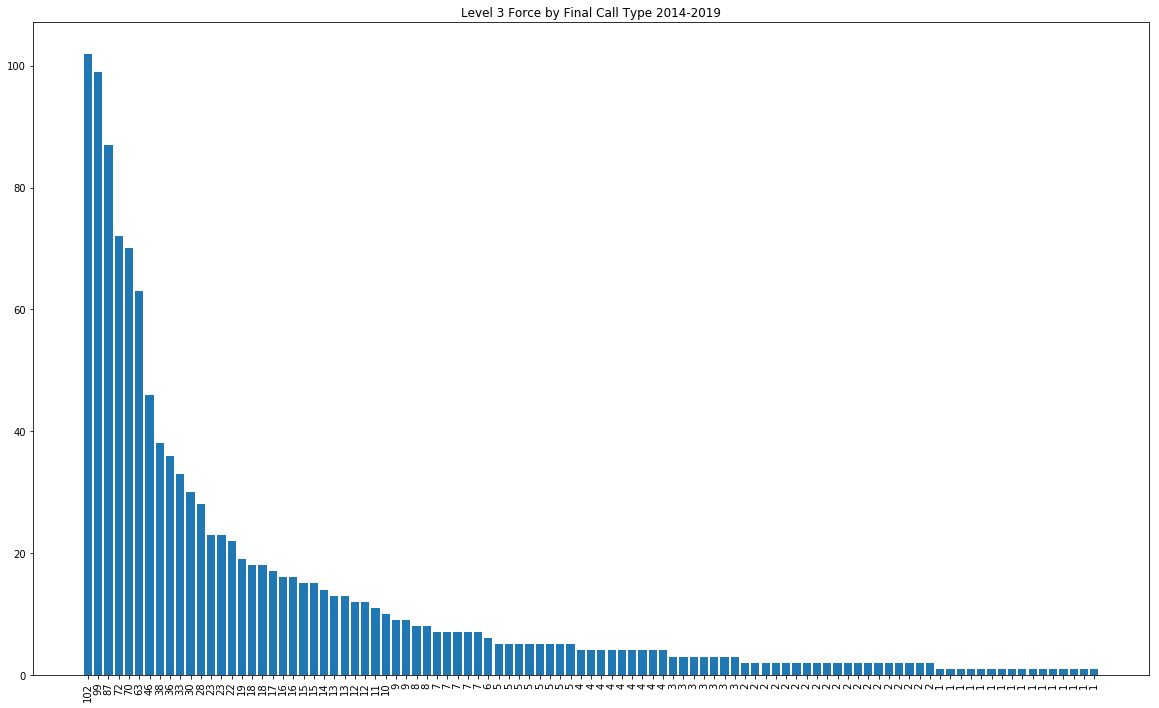

In [106]:

fig, ax = plt.subplots(1,1, figsize=(20,12))
fct = force3.Final_Call_Type.value_counts()
lst = list(fct.values)
plt.bar(np.arange(99), lst)
#plt.xticks([])
#plt.xticks()

plt.xticks(np.arange(99), lst,  rotation='vertical')
plt.title("Level 3 Force by Final Call Type 2014-2019");

In [85]:
len(force3.Final_Call_Type.value_counts())

99

In [108]:
len(force3.Final_Call_Type.value_counts().index)

99